In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cpu')
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
  torch.cuda.manual_seed(seed)
  device = torch.device('cuda')

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=2, downscale=False):
    """Implements the ResNet block

    Parameters
    ----------
    in_channels: int
      Number of input channels.
    out_channels: int
      Number of output channels.
    kernel_size: int
      Kernel size. It is assumed it is a square-sized kernel. So this size is for both x and y.
    stride: int
      Controls the stride.

    """
    super(ResBlock, self).__init__()
    self.skip = nn.Sequential()
    self.downscale = downscale

    if stride != 1 or in_channels != out_channels:
      self.skip = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels)
    )
    else:
      self.skip = None

    out_channels1 = 8
    self.block = nn.Sequential(
      nn.Conv2d(in_channels=in_channels, out_channels=out_channels1, kernel_size=kernel_size, padding=1, stride=1, bias=False),
      nn.BatchNorm2d(out_channels1),
      nn.ReLU(),
      nn.Conv2d(in_channels=out_channels1, out_channels=out_channels, kernel_size=kernel_size, padding=1, stride=1, bias=False),
      nn.BatchNorm2d(out_channels)
    )

  def forward(self, x):
    identity = x
    if self.downscale:
      x = F.interpolate(x, size=(32, 32), mode="bicubic", align_corners=True)
    out = self.block(x)

    # out += identity
    out = F.relu(out)
    return out

In [ ]:
!pip install learn2learn

In [ ]:
import learn2learn as l2l
import torchvision
from torchvision import transforms

# omniglot = l2l.vision.datasets.FullOmniglot(root='./data',
#                                             transform=transforms.Compose([
#                                                 transforms.Resize(32),
#                                                 transforms.ToTensor(),
#                                                 lambda x: 1.0 - x,
#                                             ]),
#                                             download=True)
# omniglot = l2l.data.MetaDataset(omniglot)

In [ ]:
# Load train/validation/test tasksets using the benchmark interface
ways = 5
shots = 1
meta_batch_size = 16
tasksets = l2l.vision.benchmarks.get_tasksets(
    'omniglot',
    train_ways=ways,
    train_samples=2*shots,
    test_ways=ways,
    test_samples=2*shots,
    num_tasks=12000,
    root='~/data',
)

num_iterations = 1

for iteration in range(num_iterations):
  for task in range(meta_batch_size):
    batch = tasksets.train.sample()
    break

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# from learn2learn.vision.models import OmniglotCNN
# ocnn = OmniglotCNN(output_size=5, hidden_size=64, layers=3)

In [ ]:
batch[0].shape, batch[1].shape

(torch.Size([10, 1, 28, 28]), torch.Size([10]))

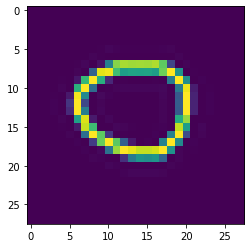

In [ ]:
plt.imshow(batch[0][1].squeeze(0).numpy())

In [ ]:
class EBMM(nn.Module):
  """Implements the fully-connected memory module."""
  def __init__(self, input_size, batch_size):
    super(EBMM, self).__init__()

    channels = 1
    self.hidden_size = 512
    self.batch_size = batch_size
    self.state = torch.zeros(self.batch_size, self.hidden_size)
    self.representation_size = 512
    self.dynamic_size = (input_size - 1) // 2
    self.static_size = self.representation_size - self.dynamic_size
    self.encoder = nn.Sequential(
      ResBlock(channels, 16, kernel_size=3, stride=2, downscale=False),
      ResBlock(16, 32, kernel_size=3, stride=2, downscale=False),
      ResBlock(32, 64, kernel_size=3, stride=2, downscale=False),
      nn.Flatten(),
      nn.Linear(50176, 256),
      nn.LayerNorm(256)
    )
    self.gate = nn.Sequential(
      nn.Linear(1024, self.hidden_size),
      nn.Sigmoid()
    )
    self.hidden = nn.Sequential(
      nn.Linear(1024, self.hidden_size),
      nn.Tanh()
    )

    self.input_size = input_size
    self.dynamic_size = (self.input_size - 1) // 2
    self.memory = nn.Linear(256, self.dynamic_size)

  def forward(self, x):
    x = self.encoder(x)

    dynamic_part = self.memory(x)
    static_part = nn.Linear(256, self.static_size)(x)
    x = torch.tanh(torch.cat((dynamic_part, static_part), axis=1))
    for hop in range(3):
      z = torch.cat((x, self.state), axis=1)
      c = self.hidden(z)
      c = nn.LayerNorm(512)(c)
      u = self.gate(z)
      self.state = u * c + (1 - u) * c

    self.state = self.state.reshape(self.batch_size, -1)
    h = torch.tanh(nn.Linear(512, 1024)(self.state))
    energy = nn.Linear(1024, 1)(h)
    return energy

class EBMMDecoder(nn.Module):
  """EBMM decoder to retrieve images."""
  def __init__(self, channels=1):
    super(EBMMDecoder, self).__init__()

    self.decoder = nn.Sequential(
      ResBlock(1, 32, kernel_size=3, stride=2, downscale=False),
      ResBlock(32, 16, kernel_size=3, stride=2, downscale=False),
      ResBlock(16, 1, kernel_size=3, stride=2, downscale=False),
    )

  def forward(self, x):
    return self.decoder(x)

# class EBMMDecoder2(nn.Module):
#   def __init__(self, channels=1):
#     super(EBMMDecoder2, self).__init__()

#   def forward(self, x, alpha, energy_grad):
#     return x - alpha * energy_grad

In [ ]:
batch[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
batch_size = batch[0].shape[0]
ebmm = EBMM(784, batch[0].shape[0])  # 784 for omniglot (28 * 28)

In [ ]:
ebmm_decoder = EBMMDecoder()
# ebmm_decoder2 = EBMMDecoder2(100)

In [ ]:
def random_block_distort(images):
  portion_size = (7, 7)  # Shape of distortion block

  images_copy = images.clone().detach()

  for image in images_copy:
    for img in image:
      image_size = img.shape

      x1 = random.randint(0, image_size[0]-portion_size[0]-1)
      y1 = random.randint(0, image_size[1]-portion_size[1]-1)
      x2, y2 = x1 + portion_size[0] - 1, y1 + portion_size[1] - 1
      num_elements = (abs(x1 - x2), abs(y1 - y2))

      img[y1:y2, x1:x2] = torch.randn(num_elements[0], num_elements[1])

  return images_copy

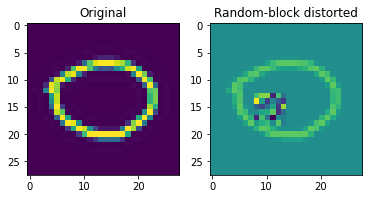

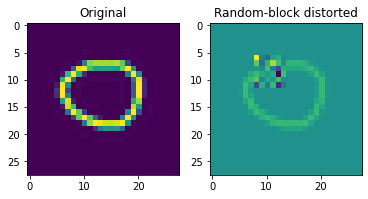

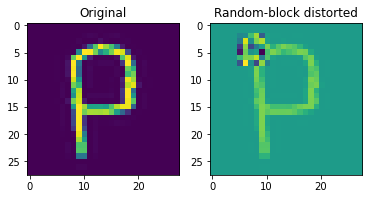

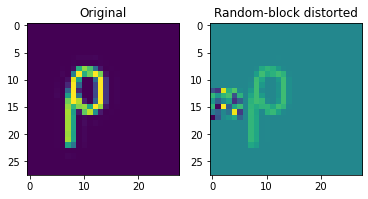

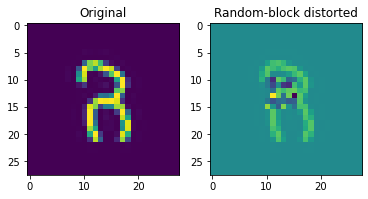

In [ ]:
modified_batch = random_block_distort(batch[0])
index = 0
for i, j in zip(batch[0], modified_batch):
  fig,ax=plt.subplots(1,2)
  ax[0].imshow(i.squeeze().numpy())
  ax[0].set_title("Original")
  ax[1].imshow(j.squeeze().numpy())
  ax[1].set_title("Random-block distorted")
  plt.show()

  index += 1
  if index == 5:
    break

In [ ]:
# Random erasing
rande = torchvision.transforms.RandomErasing(p=1.)

In [ ]:
def writing_loss(energy, alpha, energy_grad):
  return energy + alpha * energy_grad

In [ ]:
# optimizer = torch.optim.Adam(ebmm_decoder.parameters(), lr=5e-5, weight_decay=1e-6)
# woptimizer = torch.optim.Adam(ebmm.parameters(), lr=1e-4)

maml = l2l.algorithms.MAML(ebmm_decoder, lr=0.5)  # lr is the fast adaptation learning rate which is generally greater than the meta learning rate.

optimizer = optim.Adam(maml.parameters(), lr=5e-5)
woptimizer = optim.Adam(ebmm.parameters(), lr=5e-5)

In [ ]:
class WritingLoss(nn.Module):
  def __init__(self):
    super(WritingLoss, self).__init__()

  def forward(self, energy):
    return energy

wl = WritingLoss()

In [ ]:
# criterion = nn.MSELoss()
# criterion = WritingLoss()

In [ ]:
!pip install piqa

In [ ]:
from piqa import SSIM

# class SSIMLoss(SSIM):
#   def forward(self, x, y):
#     return 1. - super().forward(x, y)

# criterion = SSIMLoss() # .cuda() if you need GPU support
# criterion =  SSIM(n_channels=1)
mse_loss = nn.MSELoss()

class SSIMLoss(SSIM):
  def forward(self, x, y):
    return 1. - super().forward(x, y)

criterion = SSIMLoss(n_channels=1)

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# ebmm = ebmm.to(device)
# ebmm_decoder = ebmm_decoder.to(device)

In [ ]:
def normalize_each_in_batch(images):
  channels = 1
  _x = torch.min(images.view(batch_size, channels, -1), dim=2)[0]
  im_mins = _x.view(batch_size, channels, 1, 1)
  _y = torch.max(images.view(batch_size, channels, -1), dim=2)[0]
  im_maxs = _y.view(batch_size, channels, 1, 1)
  # im_std = images.view(batch_size, channels, -1).std(2).view(batch_size, channels, 1, 1)
  images_norm = (images - im_mins) / (im_maxs - im_mins)
  return images_norm

In [ ]:
num_iterations = 5  # Due to computational heaviness, set to 10 epochs only.
k = 5  # No. of fast read and write iterations

alpha = 0.5
gamma = 100

losses = []
for iteration in range(num_iterations):
  adapt_loss = 0.0
  for i, task in enumerate(range(meta_batch_size)):
    train_batch, test_batch = tasksets.train.sample(), tasksets.validation.sample()
    learner = maml.clone()

    train_batch[0].requires_grad = True
    test_batch[0].requires_grad = True

    # Write fixed-size batch into model.
    print("Starting write procedure")
    for wi in range(2):
      energy = ebmm(train_batch[0].float())  # Shape of energy: (batch_size, 1).
      woptimizer.zero_grad()
      # A warning about accessing the .grad attribute of a non-leaf tensor
      # appears which is expected since we assign the mean energy to a new variable.
      mean_energy = energy.mean()
      print(f'Writing iteration {wi}, Mean Batch Energy: {mean_energy}')
      # mean_energy.retain_grad()
      # mean_energy.backward(inputs=train_batch[0], retain_graph=True)
      # print(mean_energy.grad)
      # torch.autograd.set_detect_anomaly(True)
      energy_grad = torch.autograd.grad(mean_energy, train_batch[0], retain_graph=True)[0]
      wloss = mean_energy + alpha * energy_grad.mean()
      wloss.backward(inputs=train_batch[0], retain_graph=True)
      alpha *= 0.95
      woptimizer.step()

    print("\n")

    # Corrupt a random block of image.
    # query = rande(train_batch[0])
    query = random_block_distort(train_batch[0])

    decoded = query.clone().detach()
    decoded.requires_grad = True
    print("Starting read procedure")
    for _ in range(3):
      energy = ebmm(decoded)
      # energy_grad = torch.autograd.grad(energy.mean(), decoded, retain_graph=True, allow_unused=True)
      # decoded -= gamma * energy_grad[0]
      decoded = learner(query)
      energy = ebmm(decoded)
      orig = normalize_each_in_batch(train_batch[0])
      recon = normalize_each_in_batch(decoded)
      train_loss = criterion(orig, recon) + mse_loss(orig, recon)  # Use step-wise reconstruction loss.
      learner.adapt(train_loss, allow_unused=True)
      gamma *= 0.9

    energy_test = ebmm(test_batch[0].float())
    # query_test = rande(test_batch[0])
    query_test = random_block_distort(test_batch[0])

    decoded_test = query_test.clone().detach()
    decoded_test.requires_grad = True
    for _ in range(3):
      # energy_grad_test = torch.autograd.grad(energy_test.mean(), decoded_test, retain_graph=True, allow_unused=True)
      decoded_test = learner(query_test)
      energy_test = ebmm(decoded_test)
      orig_test = normalize_each_in_batch(test_batch[0])
      recon_test = normalize_each_in_batch(decoded_test)
      test_loss = criterion(orig_test, recon_test) + mse_loss(orig_test, recon_test)  # Use step-wise reconstruction loss.
      learner.adapt(test_loss, allow_unused=True)
      # decoded_test = decoded_test - 100 * energy_grad_test[0]  # Hardcode gamma to 500

    orig_test = normalize_each_in_batch(test_batch[0])
    recon_test = normalize_each_in_batch(decoded_test)

    adapt_loss += criterion(orig_test, recon_test) + mse_loss(orig_test, recon_test)

  optimizer.zero_grad()
  total_loss = adapt_loss
  total_loss.backward()
  losses.append(total_loss)
  print(f'Epoch: {iteration}\tLoss: {adapt_loss/i}')
  optimizer.step()

  # Apply gradient clipping
  # torch.nn.utils.clip_grad_norm_(ebmm.parameters(), 0.05)

Starting write procedure
Writing iteration 0, Mean Batch Energy: 0.1267329752445221
Writing iteration 1, Mean Batch Energy: 0.21735820174217224


Starting read procedure
Starting write procedure
Writing iteration 0, Mean Batch Energy: -0.13975928723812103
Writing iteration 1, Mean Batch Energy: -0.05186620354652405


Starting read procedure
Starting write procedure
Writing iteration 0, Mean Batch Energy: 0.26226750016212463
Writing iteration 1, Mean Batch Energy: 0.38599830865859985


Starting read procedure
Starting write procedure
Writing iteration 0, Mean Batch Energy: 0.17906472086906433
Writing iteration 1, Mean Batch Energy: 0.262462854385376


Starting read procedure
Starting write procedure
Writing iteration 0, Mean Batch Energy: 0.4198194146156311
Writing iteration 1, Mean Batch Energy: -0.16049917042255402


Starting read procedure
Starting write procedure
Writing iteration 0, Mean Batch Energy: -0.32413148880004883
Writing iteration 1, Mean Batch Energy: -0.06621778756380081

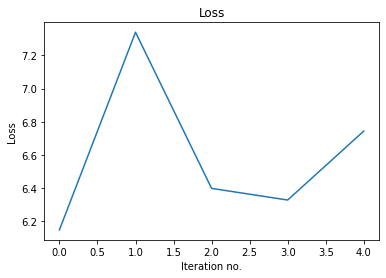

In [ ]:
plt.plot([l.detach().numpy() for l in losses]);
plt.title("Loss");
plt.xlabel("Iteration no.");
plt.ylabel("Loss");

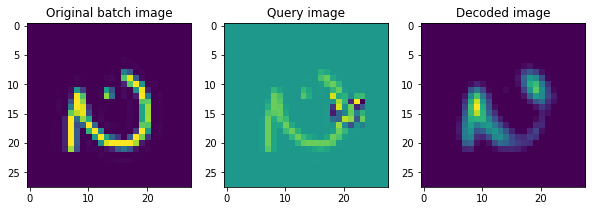

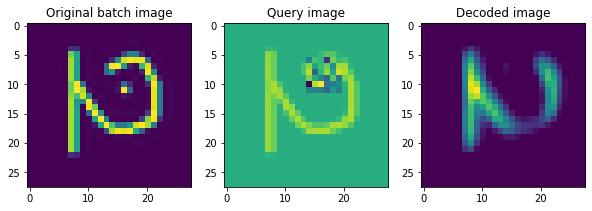

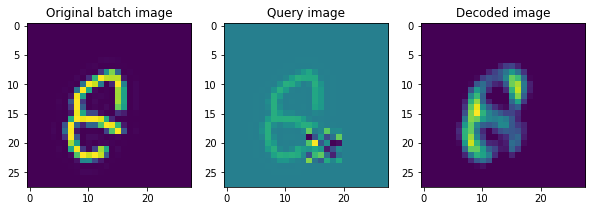

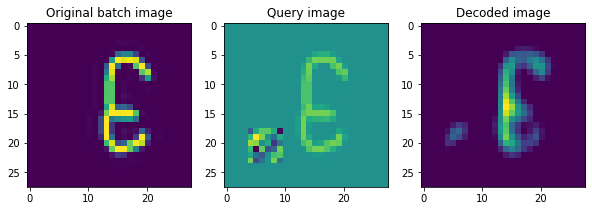

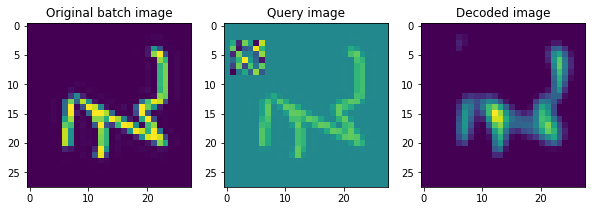

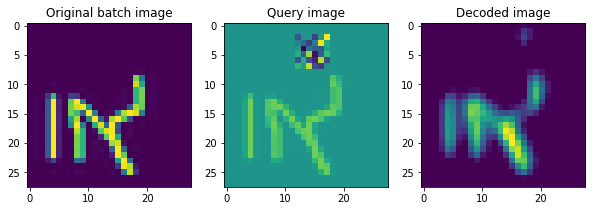

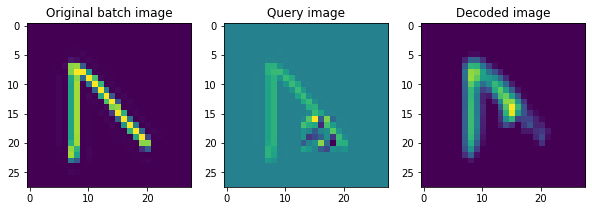

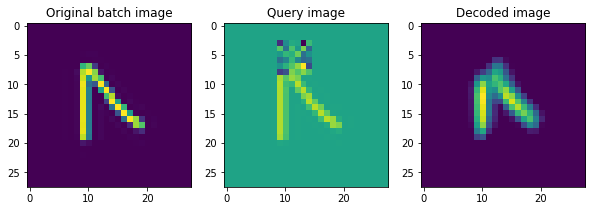

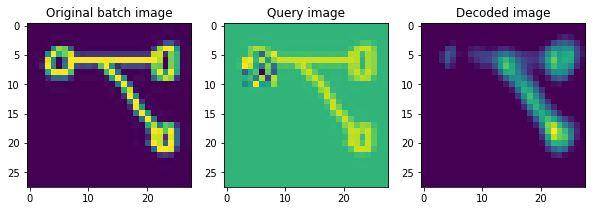

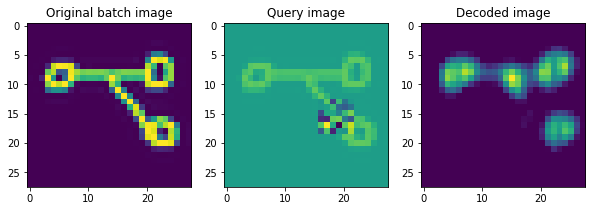

In [ ]:
for i in range(train_batch[0].shape[0]):
  fig, ax = plt.subplots(1, 3, figsize=(10, 5))
  ax[0].imshow(train_batch[0][i].squeeze().detach().numpy())
  ax[0].set_title("Original batch image")
  ax[1].imshow(query[i].squeeze().detach().numpy())
  ax[1].set_title("Query image")
  ax[2].imshow(decoded[i].squeeze().detach().numpy())
  ax[2].set_title("Decoded image")
  plt.show()

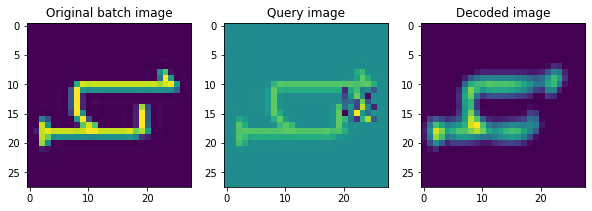

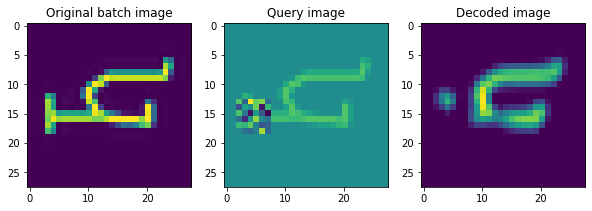

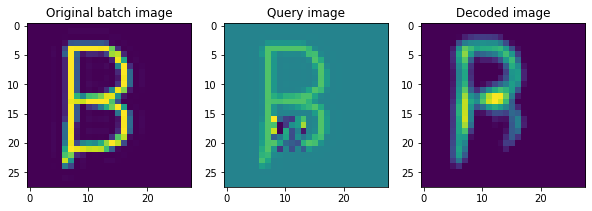

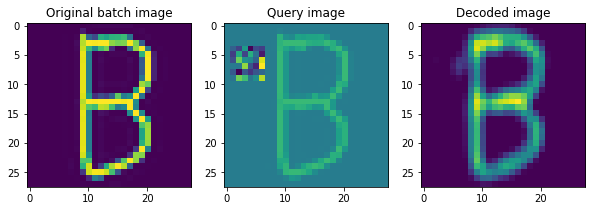

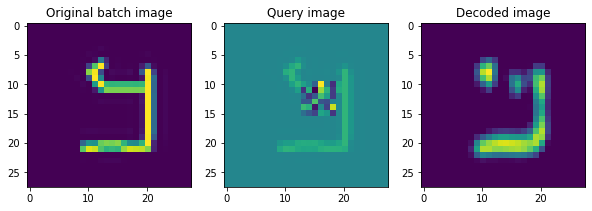

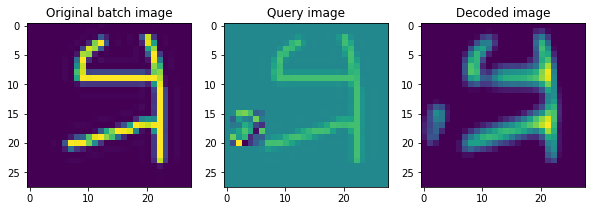

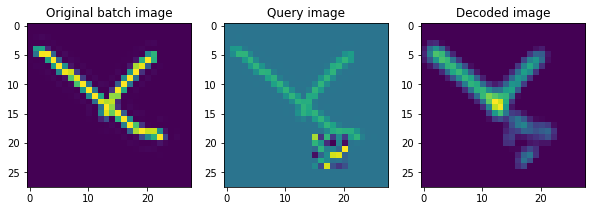

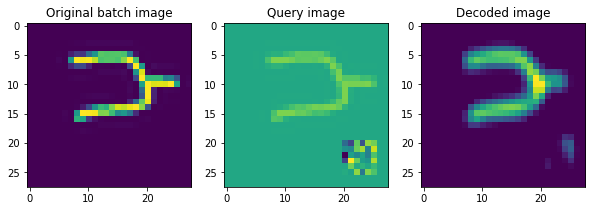

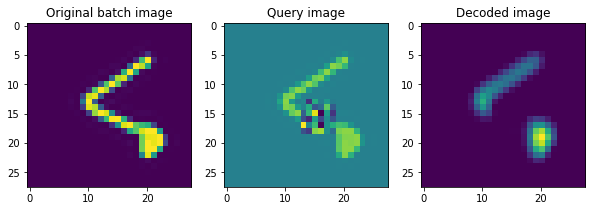

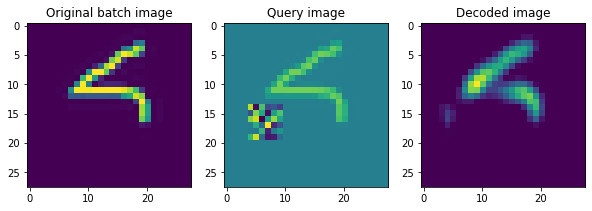

In [ ]:
ind = 0
for i in range(test_batch[0].shape[0]):
  fig, ax = plt.subplots(1, 3, figsize=(10, 5))
  ax[0].imshow(test_batch[0][i].squeeze().detach().numpy())
  ax[0].set_title("Original batch image")
  ax[1].imshow(query_test[i].squeeze().detach().numpy())
  ax[1].set_title("Query image")
  ax[2].imshow(decoded_test[i].squeeze().detach().numpy())
  ax[2].set_title("Decoded image")

  ind += 1

  if ind < 5:
    plt.savefig(f"{ind}.png", bbox_inches='tight', dpi=400)

  plt.show()

In [ ]:
de = ebmm(decoded_test)
qe = ebmm(query_test)
oe = ebmm(test_batch[0])

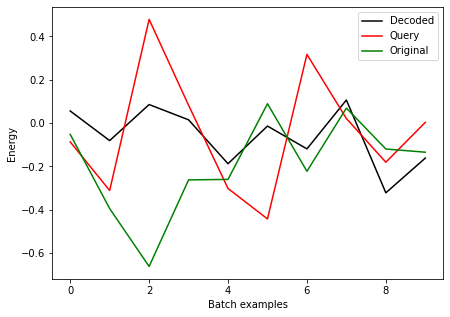

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(de.tolist(), c="black", label="Decoded");
ax.plot(qe.tolist(), c="red", label="Query");
ax.plot(oe.tolist(), c="green", label="Original");
ax.set_ylabel("Energy")
ax.set_xlabel("Batch examples")
ax.legend();

In [ ]:
de.mean(), qe.mean(), oe.mean()

(tensor(-0.0623, grad_fn=<MeanBackward0>),
 tensor(-0.0421, grad_fn=<MeanBackward0>),
 tensor(-0.1949, grad_fn=<MeanBackward0>))

In [ ]:
decoded_test.shape, query_test.shape, test_batch[0].shape

(torch.Size([10, 1, 28, 28]),
 torch.Size([10, 1, 28, 28]),
 torch.Size([10, 1, 28, 28]))